# Implementación y contraste de algoritmos de pronóstico de generación para una planta solar fotovoltaica de 80 kW de la Universidad de Los Andes

## Diego Andrés Acosta y Robinson Julián Portilla

#### En este proyecto de grado se realiza el pronóstico de generación del día siguiente de una planta solar fotovoltaica de 80 kW de la Universidad de Los Andes mediante diferentes algoritmos de Machine Learning. 

#### Se importan las librerías a utilizar 

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats

## Pre-Procesamiento de Datos

En esta etapa se realiza el pre-procesamiento de los datos empleados para realizar los modelos de pronóstico.

Los datos se encuentran en la carpeta '/DATOS SOLAR' de este repositorio. Los datos tienen una resolución de 5 minutos y consisten en la fecha (dd/mm/aa), hora (hh:mm), Potencia generada (kW), irradiación solar (W/m^2), Temperatura de los modulos (°C), Temperatura ambiente (°C) e irradiación solar media (W/m^2). Se consideraron los datos de octubre de 2019 a diciembre de 2020 para realizar el entrenamiento y evaluación de los modelos implementados. 

Cabe señalar que, puesto que la estación meteorológica de la planta no otorga datos de temperatura ambiente, esta fue estimada mediante la siguiente expresión:

#### Tamb=Tcelda-G*(TONC-20°C)/800W/m^2

Donde: 
- G es la irradiación en ese momento en W/m^2
- TONC es la temperatura nominal de la celda en °C, la cual es de 42°C para los paneles LG 400W de la planta
- Tcelda es la temperatura de los modulos fotovoltaicos en °C en ese momento
- Tamb es la temperatura ambiente en °C 

Además, con el fin de mejorar el pronóstico de los modelos de series de tiempo, se suaviazan los datos de temperatura ambiente y de insolación solar mediante un promedio móvil de ventana 11. La columna Insolación solar media corresponde a los datos de Insolación solar suaviazados.  

### Lectura de datos:
En esta etapa se leen los datos almacenados en la carpeta '/DATOS SOLAR':

In [87]:
ruta = 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\'
ruta2='C:\\Users\Diego Acosta\\Documents\\GitHub\\Proyecto-Electronica\\DATOS SOLAR\\'
mes = input('Ingrese el mes: ')
año = input('Ingrese el año: ')
try:
    datos = pd.read_csv(ruta + mes + ' ' + año + '.csv')
except:
    datos = pd.read_csv(ruta2 + mes + ' ' + año + '.csv')
datos

Ingrese el mes: Octubre
Ingrese el año: 2020


,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C],Temperatura Ambiente [C],Insolacion media [W/m2]
0,1/10/2020,0:00,x,0.98,11.05,11.448050,0.980000
1,1/10/2020,0:05,x,0.98,11.52,11.473050,0.980000
2,1/10/2020,0:10,x,0.98,11.62,11.490550,0.980000
3,1/10/2020,0:15,x,0.98,11.60,11.513050,0.980000
4,1/10/2020,0:20,x,0.98,11.55,11.555050,0.980000
...,...,...,...,...,...,...,...
8923,31/10/2020,23:35,x,0.97,13.05,13.436242,0.973000
8924,31/10/2020,23:40,x,0.97,12.96,13.369931,0.972222
8925,31/10/2020,23:45,x,0.97,13.16,13.297041,0.971250
8926,31/10/2020,23:50,x,0.97,13.48,13.249000,0.971429


### Funciones para el pre procesamiento: 

In [88]:
#Esta función reemplaza los datos ue tengan un valor de 'x' por un 0

def reemplazo(datos):
    datos.replace({'Potencia [kW]':'x'},0,inplace = True)
    datos.dropna(inplace = True)
    return datos

#Esta función toma los valores donde se observa que el sol está activo
# el intervalo de horas tomado es en un día de 6:00 am a 6:00pm. Además,
#en esta función se cambian algunos valores de temperatura ambiente 
#considerados fuera de lo normal para la ciudad de Bogotá

def intervalosolar(datos):
    list1 = datos['Hora'][0:72].tolist()
    list2 = datos['Hora'][217:288].tolist()
    
    list = list1+list2
    
    for i in range(len(list)):
        datos = datos[datos['Hora']!= list[i]]
    try:
        for i in datos['Temperatura ambiente [C]']:   
            if i<23.5:
                m=i
            if i >23.5:
                datos.replace({'Temperatura ambiente [C]':i},m,inplace=True)
    except:
        for i in datos['Temperatura Ambiente [C]']:   
            if i<23.5:
                m=i
            if i >23.5:
                datos.replace({'Temperatura Ambiente [C]':i},m,inplace=True)
    return datos



#En esta función se guarda el dataframe pre procesado en formato .csv
#en una carpeta nueva llamada '/Pre- procesados'
rutanueva = 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR'
def guardarcsv(datos,nombre):
    datos.to_csv(rutanueva+'\\Pre procesados\\'+ nombre)

#### Se crea una lista donde se guardan las rutas de los archivos a leer:

In [89]:
try:
    archivos = glob.glob('C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\*.csv')
except:
    archivos = glob.glob('C:\\Users\Diego Acosta\\Documents\\GitHub\\Proyecto-Electronica\\DATOS SOLAR\\*.csv')    

nombres = [] #Vector con los nombres de los archivos

for i in range(len(archivos)):
    nombre = archivos[i].split('\\')
    nombres.append(nombre[-1])
nombres

['Abril 2020.csv',
 'Agosto 2020.csv',
 'Diciembre 2019.csv',
 'Diciembre 2020.csv',
 'Enero 2020.csv',
 'Febrero 2020.csv',
 'Julio 2020.csv',
 'Junio 2020.csv',
 'Marzo 2020.csv',
 'Mayo 2020.csv',
 'Noviembre 2019.csv',
 'Noviembre 2020.csv',
 'Octubre 2019.csv',
 'Octubre 2020.csv',
 'Septiembre 2020.csv']

### Ejecución de funciones:

#### Se lee cada uno de los archivos y se ejecutan las diferentes funciones definidas previamente:

In [90]:
for i in range(len(archivos)):
    #Se lee el archivo de la ruta
    datos = pd.read_csv(archivos[i])
    datos = reemplazo(datos)
    datos = intervalosolar(datos)
    guardarcsv(datos, nombres[i])


#### Se muestra un ejemplo de cómo queda el dataframe final:

In [91]:
datos

,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C],Temperatura ambiente [C],Insolacion media [W/m2]
72,1/09/2020,6:00,0.01,5.08,9.64,9.399891,6.880000
73,1/09/2020,6:05,0.08,7.02,9.53,9.407027,8.934545
74,1/09/2020,6:10,0.17,9.42,9.40,9.437618,11.789091
75,1/09/2020,6:15,0.29,11.87,9.38,9.478893,15.015455
76,1/09/2020,6:20,0.44,14.96,9.52,9.524152,18.493636
...,...,...,...,...,...,...,...
8564,30/09/2020,17:40,0.17,8.58,15.75,14.952441,13.696364
8565,30/09/2020,17:45,0,3.21,15.58,14.665530,10.542727
8566,30/09/2020,17:50,0,1.75,15.54,14.372573,7.807273
8567,30/09/2020,17:55,0,1.07,14.91,14.089477,4.845455


## Análisis estadístico y de desempeño de la planta solar fotovoltaica 

En esta sección se realiza el análisis estadístico y de desempeño de los datos de potencia generada, irradiación solar y temperatura ambiente registrados de octubre de 2019 a diciembre de 2020 por la estación meteorológica de la planta solar fotovoltaica. 

In [92]:
# Recibe un dataframe de datos de la planta y la variable a analizar

def soldiario(datos,variable = 'Insolacion [W/m2]'):
    fechas = datos['Fecha'].unique()
    solxdia = []
    for i in range(len(fechas)):
        solxdia.append(datos[datos['Fecha']==fechas[i]].sum()[variable]/12 )
    df = {'Dia':fechas, variable:solxdia}
    df = pd.DataFrame(df)
    return df

In [93]:
ruta = 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\'
ruta2 = 'C:\\Users\Diego Acosta\\Documents\\GitHub\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\'
try:
    archivospre = glob.glob(ruta +'*.csv')
except:
    archivospre = glob.glob(ruta2 +'*.csv')
archivospre

['C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Abril 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Agosto 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Diciembre 2019.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Diciembre 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Enero 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Febrero 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre pro

In [95]:
nombres2 = []
for i in range(len(archivospre)):
    nombre = archivos[i].split('\\')
    nombres2.append(nombre[-1])
nombres2

['Abril 2020.csv',
 'Agosto 2020.csv',
 'Diciembre 2019.csv',
 'Diciembre 2020.csv',
 'Enero 2020.csv',
 'Febrero 2020.csv',
 'Julio 2020.csv',
 'Junio 2020.csv',
 'Marzo 2020.csv',
 'Mayo 2020.csv',
 'Noviembre 2019.csv',
 'Noviembre 2020.csv',
 'Octubre 2019.csv',
 'Octubre 2020.csv',
 'Septiembre 2020.csv']

#### Se crea un dataframe llamado 'todo' que contiene los datos  por día de una variable específica de los dataframes pre procesados anteriormente

In [100]:
i=0
variable = 'Insolacion [W/m2]'
#variable = 'Potencia [kW]'

for nombre in nombres2:
    df = pd.read_csv(nombre)
    
    try: 
        df = df.drop('Unnamed: 0',axis=1)
    except:
        pass
    
    df = df.dropna()
    
    name = nombre.split('.') 
    name = name[0].split(' ')
    
    globals()[name[0] + name[1]] = soldiario(df,variable)
    
    if i == 0:
        todo = globals()[name[0] + name[1]] # DataFrame donde se guardan los diferentes valores de insolación por día.
    else:
        todo = pd.concat([todo , globals()[name[0] + name[1]]],axis = 0)
    i+=1

In [101]:
inso_max = todo[variable].max()
inso_min = todo[variable].min()

intervalos = np.linspace(inso_min, inso_max, 15)
print(intervalos)

[1053.07333333 1442.5160119  1831.95869048 2221.40136905 2610.84404762
 3000.28672619 3389.72940476 3779.17208333 4168.6147619  4558.05744048
 4947.50011905 5336.94279762 5726.38547619 6115.82815476 6505.27083333]


## Histograma de insolación media diaria

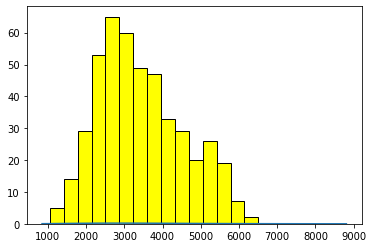

In [102]:
plt.figure()
plt.hist(todo['Insolacion [W/m2]'],15,color = 'yellow',ec = 'k') #Histograma de frecuencias de insolación diaria media
#plt.hold(True)
# Graficando Gamma
a = 4.5 # parametro de forma.
gamma = stats.gamma(a)
x = np.linspace(gamma.ppf(0.01),
                gamma.ppf(0.99), 100)
fp = gamma.pdf(x) # Función de Probabilidad
plt.plot(x*todo['Insolacion [W/m2]'].max()/8, fp)
plt.show()

In [ ]:
plt.hist(todo['Insolacion [W/m2]'],15,color = 'yellow',ec = 'k')